In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

Dataset generation

In [31]:
def generate_data(samples_per_class=200):
    X = []
    y = []
    for class_num in range(5):
        mean = np.random.uniform(-5, 5, 2)
        cov = np.eye(2) * np.random.uniform(0.5, 1.5)
        Xi = np.random.multivariate_normal(mean, cov, samples_per_class)
        yi = np.full(samples_per_class, class_num)
        X.append(Xi)
        y.append(yi)
    return np.vstack(X), np.hstack(y)

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

Activation functions and derivatives

In [32]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

Loss function

In [33]:
def cross_entropy(pred, true):
    m = true.shape[0]
    loss = -np.sum(true * np.log(pred + 1e-9)) / m
    return loss

Accuracy

In [34]:
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

Neural Network class

In [35]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.01):
        self.lr = learning_rate
        self.params = {
            "W1": np.random.randn(input_size, hidden_sizes[0]) * 0.1,
            "b1": np.zeros((1, hidden_sizes[0])),
            "W2": np.random.randn(hidden_sizes[0], hidden_sizes[1]) * 0.1,
            "b2": np.zeros((1, hidden_sizes[1])),
            "W3": np.random.randn(hidden_sizes[1], hidden_sizes[2]) * 0.1,
            "b3": np.zeros((1, hidden_sizes[2])),
            "W4": np.random.randn(hidden_sizes[2], output_size) * 0.1,
            "b4": np.zeros((1, output_size))
        }

    def forward(self, X):
        z1 = X @ self.params["W1"] + self.params["b1"]
        a1 = relu(z1)
        z2 = a1 @ self.params["W2"] + self.params["b2"]
        a2 = relu(z2)
        z3 = a2 @ self.params["W3"] + self.params["b3"]
        a3 = relu(z3)
        z4 = a3 @ self.params["W4"] + self.params["b4"]
        a4 = softmax(z4)
        return z1, a1, z2, a2, z3, a3, z4, a4

    def backward(self, X, y_true, cache):
        z1, a1, z2, a2, z3, a3, z4, a4 = cache
        m = X.shape[0]

        dz4 = a4 - y_true
        dW4 = (a3.T @ dz4) / m
        db4 = np.sum(dz4, axis=0, keepdims=True) / m

        dz3 = (dz4 @ self.params["W4"].T) * relu_derivative(z3)
        dW3 = (a2.T @ dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        dz2 = (dz3 @ self.params["W3"].T) * relu_derivative(z2)
        dW2 = (a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.params["W2"].T) * relu_derivative(z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights
        self.params["W1"] -= self.lr * dW1
        self.params["b1"] -= self.lr * db1
        self.params["W2"] -= self.lr * dW2
        self.params["b2"] -= self.lr * db2
        self.params["W3"] -= self.lr * dW3
        self.params["b3"] -= self.lr * db3
        self.params["W4"] -= self.lr * dW4
        self.params["b4"] -= self.lr * db4

    def train(self, X, y, epochs=1000):
        losses = []
        for epoch in range(epochs):
            cache = self.forward(X)
            loss = cross_entropy(cache[-1], y)
            losses.append(loss)
            self.backward(X, y, cache)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        _, _, _, _, _, _, _, a4 = self.forward(X)
        return np.argmax(a4, axis=1)

Main flow

In [36]:
X, y = generate_data(samples_per_class=200)
y_onehot = one_hot(y, 5)

Shuffle and split

In [37]:
indices = np.random.permutation(X.shape[0])
split = int(0.8 * len(indices))
train_idx, test_idx = indices[:split], indices[split:]

X_train, y_train = X[train_idx], y_onehot[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

nn = NeuralNetwork(input_size=2, hidden_sizes=[64, 32, 16], output_size=5, learning_rate=0.01)
losses = nn.train(X_train, y_train, epochs=1000)

Epoch 100/1000, Loss: 1.5832
Epoch 200/1000, Loss: 1.5428
Epoch 300/1000, Loss: 1.4457
Epoch 400/1000, Loss: 1.2227
Epoch 500/1000, Loss: 0.9986
Epoch 600/1000, Loss: 0.8582
Epoch 700/1000, Loss: 0.7506
Epoch 800/1000, Loss: 0.6575
Epoch 900/1000, Loss: 0.5782
Epoch 1000/1000, Loss: 0.5127


Evaluate

In [38]:
y_pred = nn.predict(X_test)
acc = accuracy(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8000


Plot loss

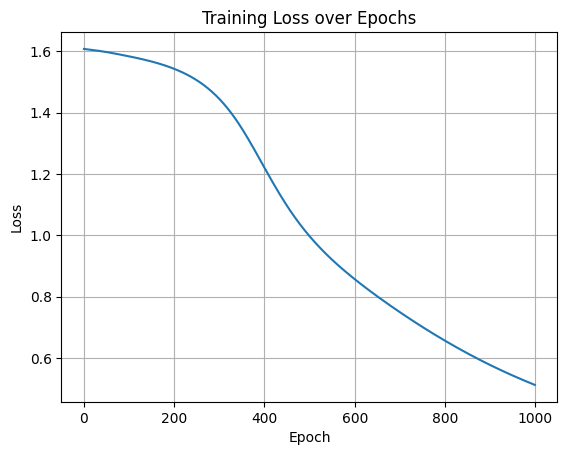

In [39]:
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Test Accuracy: 0.8000

Classification Report:
Class 0: Precision = 0.6667, Recall = 0.85, F1-score = 0.7473, Support = 40
Class 1: Precision = 1.0, Recall = 1.0, F1-score = 1.0, Support = 31
Class 2: Precision = 1.0, Recall = 1.0, F1-score = 1.0, Support = 31
Class 3: Precision = 0.6571, Recall = 0.451, F1-score = 0.5349, Support = 51
Class 4: Precision = 0.7885, Recall = 0.8723, F1-score = 0.8283, Support = 47


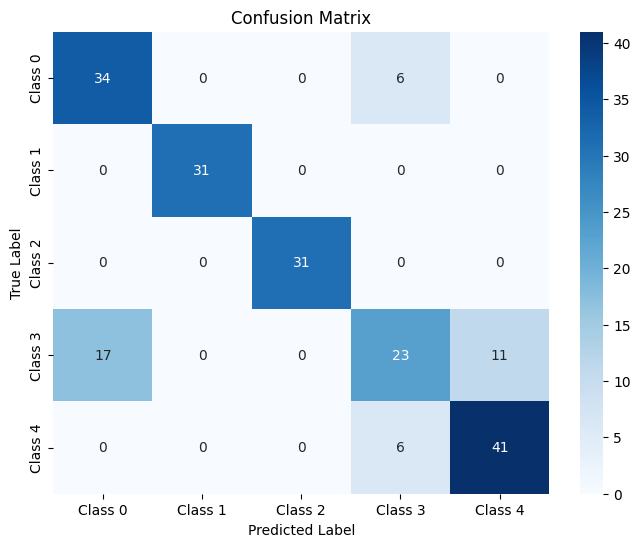

In [40]:
y_pred = nn.predict(X_test)
acc = accuracy(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
# Compute confusion matrix
conf_matrix = np.zeros((5, 5), dtype=int)
for true_label, pred_label in zip(y_test, y_pred):
    conf_matrix[true_label][pred_label] += 1

# Compute precision, recall, F1-score
def classification_report_manual(y_true, y_pred, num_classes=5):
    report = {}
    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        precision = tp / (tp + fp + 1e-9)
        recall = tp / (tp + fn + 1e-9)
        f1 = 2 * precision * recall / (precision + recall + 1e-9)

        report[f"Class {c}"] = {
            "Precision": round(precision, 4),
            "Recall": round(recall, 4),
            "F1-score": round(f1, 4),
            "Support": int(np.sum(y_true == c))
        }

    return report

report = classification_report_manual(y_test, y_pred)

print("\nClassification Report:")
for cls, metrics in report.items():
    print(f"{cls}: ", end="")
    print(", ".join([f"{k} = {v}" for k, v in metrics.items()]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(5)],
            yticklabels=[f"Class {i}" for i in range(5)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
